# Classification

Explore classification systems.

# MNIST

MNIST is a dataset of 70,000 small handwritten digits.

### OpenML

According to the official [OpenML](https://www.openml.org/) site description: *"OpenML is an open platform for sharing datasets, algorithms, and experiments - to learn how to learn better, together."*

`scikit-learn` provides [fetch_openml](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html) API to download datasets from the OpenML [datasets collection](https://www.openml.org/search?type=data&sort=runs&status=active) (which also includes `Fashion-MNIST`).

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, data_home="./datasets")
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
import numpy as np

X = mnist["data"].to_numpy()
y = mnist["target"].to_numpy().astype(np.uint8)

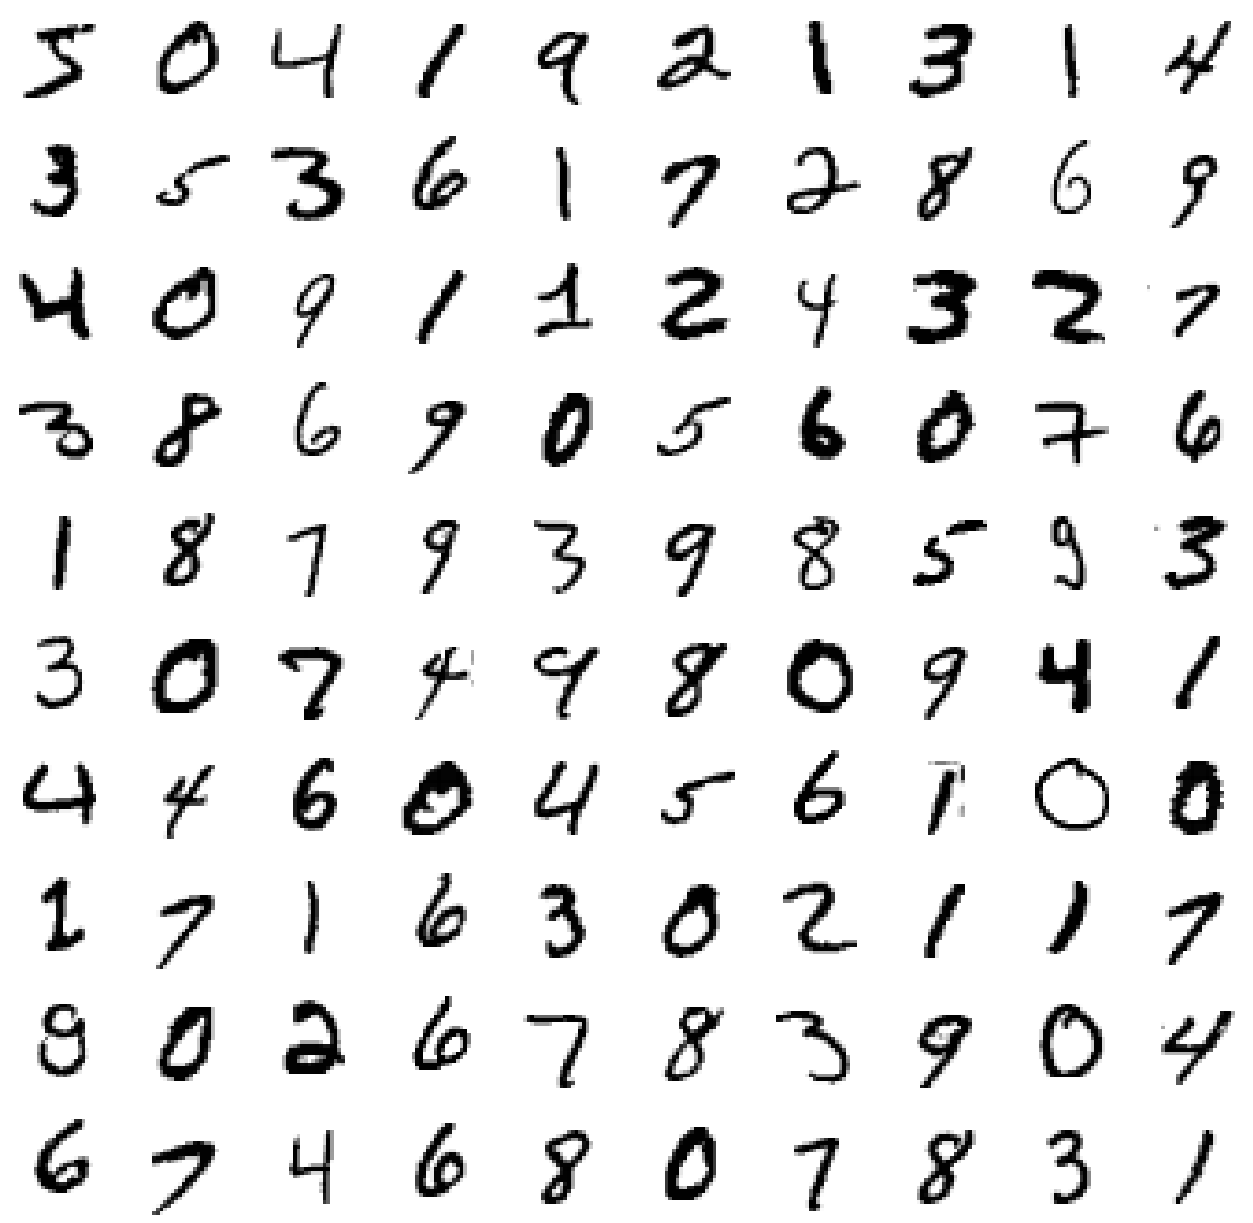

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 20), dpi=80)
w, h = 10, 10
for i in range(w * h):
    axes = fig.add_subplot(w, h, i+1)
    digit = X[i].reshape(28, 28)
    axes.imshow(digit, cmap=mpl.cm.binary, interpolation="nearest")
    axes.axis("off")

In [4]:
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

### Create Test Set

MNIST is already split into a training set (the firt 60k) and test set (the last 10k)

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

Let's create labels for binary classifier. 

In [6]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

y_train_5

array([ True, False, False, ...,  True, False, False])

Let's start with Stochastic Gradient Descent (SGD) classifier, which is capable of handling very large datasets efficiently. This is due to the fact that SGD deals with training instances independently (which makes it suitable for *online learning*). 

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [8]:
sgd_clf.predict(X[:20])

array([ True, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False])

In [9]:
y_train_5[:20]

array([ True, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False])

# Performance Measures

Evaluating classifier is often significant trikier (*but why?*). There are many performance measures. 

In [15]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    sgd_clf, 
    X_train, 
    y_train_5, 
    scoring="accuracy", 
    cv=3,
)

scores

array([0.95035, 0.96035, 0.9604 ])

The accuracy is pretty high! 

**BUT WAIT!**

What is the proportion of the 5s in the original dataset?

In [14]:
ratio = float(sum(y_train_5))/len(y_train)
print("Portion:", ratio)
print("All negative accuracy:", 1 - ratio)

Portion: 0.09035
All negative accuracy: 0.90965


Let's create a dummy all-negative binary classifier. 

In [18]:
from sklearn.base import BaseEstimator

class NeverClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = NeverClassifier()
cross_val_score(
    never_5_clf,
    X_train,
    y_train_5,
    scoring="accuracy",
    cv=3
)

array([0.91125, 0.90855, 0.90915])

**NOTE**: Almost the save accuracy as for `SGDClassifier`! This is simply because only ~10% of the images are 5s.

**This demonstrates why accuracy is generally not the preferred performance measure for classifiers**, especially with *skewed datasets* (i.e. when some classes are much more frequent than others).

# Confusion Matrix

Each row in a confusion matrix represents an actual class, while each column represents a predicted class

In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Get cross-validation predictions:
y_train_5_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
conf_matrix = confusion_matrix(y_train_5, y_train_5_pred)
conf_matrix

array([[53892,   687],
       [ 1891,  3530]])

# Precision and Recall

Let's try to calculate $precision = \frac{TP}{TP+FP}$

In [21]:
float(conf_matrix[1,1])/sum(conf_matrix[:, 1])

0.8370879772350012

Let's calculate $recall = \frac{TP}{TP + FN}$

In [24]:
float(conf_matrix[1,1])/sum(conf_matrix[1])

0.6511713705958311

Scikit-Learn provides API to calculate classifier metrics:

In [32]:
from sklearn.metrics import precision_score

precision_score(y_train_5, y_train_5_pred)

0.8370879772350012

In [33]:
from sklearn.metrics import recall_score

recall_score(y_train_5, y_train_5_pred)

0.6511713705958311

A convenient way to combine *precission* and *recall* is to use the $F_1$ metric. This is a handy tool to compare two classifiers. The $F_1$ metric is a *harmonic mean* of precision and recall. 

**NOTE**: the harmonic mean gives much more weight to low values, i.e. the classifier will only get a high $F_1$ score if both recall and precision are high:

$$
F_1 = 2 \times \frac{precision \times recall}{precision+recall}
$$

In [34]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_5_pred)

0.7325171197343846

# Precision/Recall Tradeoff

The binary `SGDClassifier` computes scores for each instance and then decides that this is a `True`-class if `score > threshold`

Let's compute scores for each instance from the training set.

In [35]:
y_scores = cross_val_predict(
    sgd_clf, 
    X_train, 
    y_train_5, 
    cv=5,
    method="decision_function"
)

In [36]:
y_scores

array([  4411.53413566, -14087.12193543, -21565.51993633, ...,
         9394.4695853 ,  -2918.25117218,  -9160.6081938 ])

Now that we have scores for each instance we can compute a precision and recall for different `threshold` values and plot the corresponding graphs. The Scikit-Learn's [precision_recall_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) function does exactly that. 

In [39]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(
    y_train_5,
    y_scores
)

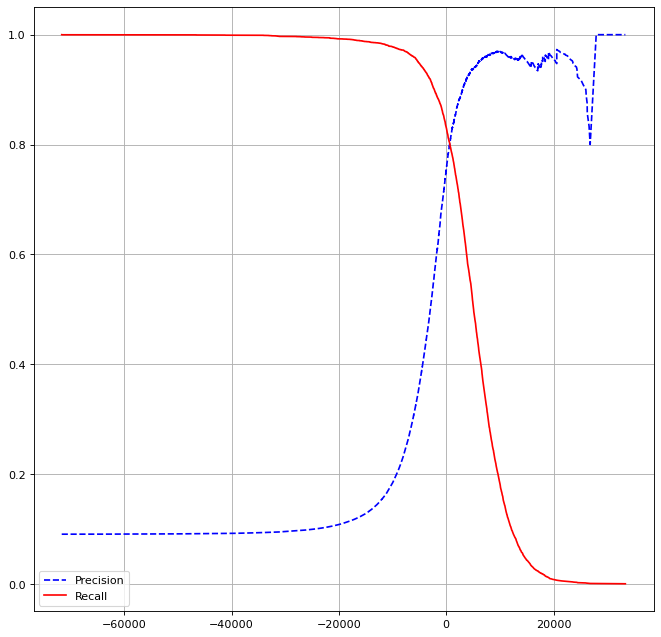

In [48]:
def plot_precision_recall(precisions, recalls, thresholds):
    fig = plt.figure(figsize=(10, 10), dpi=80)
    axes = fig.add_subplot(1, 1, 1)
    axes.plot(thresholds, precisions[:-1], "b--", label="Precision")
    axes.plot(thresholds, recalls[:-1], "r", label="Recall")
    axes.grid(visible=True)
    axes.legend()
    
plot_precision_recall(precisions, recalls, thresholds)

**NOTE** that there is a trade-off between precision and recall. The highest values of the precision presumes the lowest recall and vice-versa. 

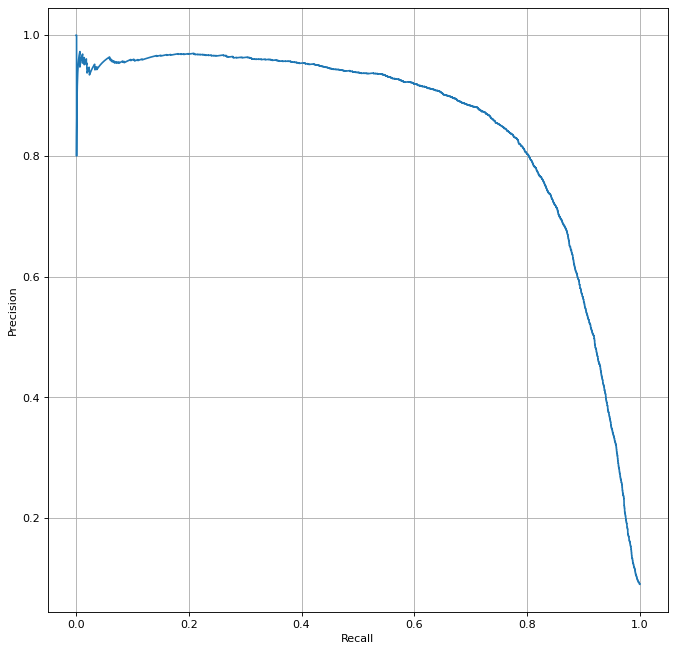

In [47]:
fig = plt.figure(figsize=(10,10), dpi=80)
axes = fig.add_subplot(1, 1, 1)
axes.plot(recalls, precisions)
axes.set_xlabel("Recall")
axes.set_ylabel("Precision")
axes.grid(visible=True)

**NOTE** that precision starts to fall sharply around 80% recall. The choice of precision/recall depends on the project.